In [57]:
import os
import sys

sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname('../..'))))

import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from src.models.feature.GooLeNet import GoogLeNet
from src.models.feature.ResNet import ResNet18
from src.models.module.pooling import GVAP, GAP
from torch.nn import functional as F

In [58]:
if torch.cuda.is_available():
    device = 'cuda'
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    device = 'cpu'
    torch.set_default_tensor_type('torch.FloatTensor')

class_name = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
#class_name = ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']

model = ResNet18(classes=len(class_name),alpha=1,cal='plus').to(device)

model.load_state_dict(torch.load('./pretrain/resnet18_cifar10_gvap_model_plus_1.pth'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [59]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Block1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
      (relu2): ReLU()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1):

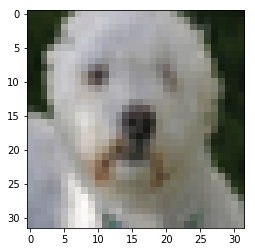

In [63]:
img_path = './test_img/cifar10/test3.png'

img = Image.open(img_path)

plt.imshow(img)

target_class = 5

In [64]:
import torchvision.transforms as transforms
from torch.autograd import Variable

cvt_tensor = transforms.Compose([transforms.Resize((128,128)),
                                 transforms.ToTensor()])

tensor_img = cvt_tensor(img).to(device)

tensor_img = tensor_img.view(1, 3, 128, 128)

tensor_img = Variable(tensor_img, requires_grad=True)

In [65]:
gradients = None

def hook_function(module, grad_input, grad_output):
    global gradients
    
    gradients = grad_input[0]
    
first_layer = list(model._modules.items())[0][1]
first_layer.register_backward_hook(hook_function)

In [66]:
output = model(tensor_img).to(device)

In [67]:
model.zero_grad()

In [68]:
one_hot_output = torch.cuda.FloatTensor(1, output.size()[-1]).zero_()
one_hot_output[0][target_class] = 1

In [69]:
output.backward(gradient=one_hot_output)

In [70]:
grad_img = gradients.cpu().data.numpy()[0]

In [71]:
grad_img = grad_img - grad_img.min()
grad_img = grad_img / grad_img.max()

In [72]:
grad_img = grad_img.transpose(1,2,0)

if np.max(grad_img) <= 1:
    grad_img = (grad_img*255).astype(np.uint8)

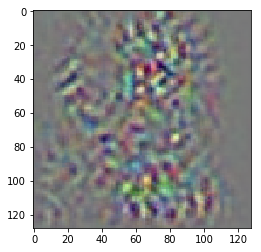

In [73]:
plt.imshow(grad_img)